# Clustering with DBSCAN (Final)

In order to identify areas of focus, we will do clustering to determine the various clusters. Our focus is to identify most efficient route for patrolling, therefore, narrowing it down to area based since police department patrol routes would be within their area of jurisdiction. 

## Loading the libraries

In [1]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import folium
from folium.plugins import HeatMap, MarkerCluster, AntPath
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from scipy.ndimage import maximum_filter, label

In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils, genetic_algo

## Load data

In [3]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"
spark = utils.start_spark()
df = utils.prepare_data(spark, data_path)
df = utils.feature_engineering(df)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/08 22:46:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/08 22:46:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
print(df.columns)

['Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION', 'LAT', 'LON', 'Occ DateTime', 'Year OCC', 'Month OCC', 'Day OCC', 'age_group', 'Category']


24/11/08 22:46:59 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Keeping only the AREA, LAT, LON for clustering purpose, since these are the information for routing. 

In [5]:
columns_to_drop = ['Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION', 'Occ DateTime', 'Year OCC', 'Month OCC', 'Day OCC', 'age_group', 'Category']
df_clean = utils.drop_columns(df, columns_to_drop)

In [6]:
df_pd = df_clean.toPandas()
df_pd.head()

,AREA,LAT,LON
0,7,34.0375,-118.3506
1,1,34.0444,-118.2628
2,3,34.0210,-118.3002
3,9,34.1576,-118.4387
4,6,34.0944,-118.3277


We will focus from the highest crime rate to the lowest crime rate area.

In [7]:
crime_rate_by_area = df_pd[["AREA"]].groupby("AREA").size().sort_values(ascending=False)
sorted_area = crime_rate_by_area.index.to_list()
print(sorted_area)

[1, 12, 14, 3, 6, 15, 18, 20, 13, 7, 2, 8, 11, 9, 10, 17, 5, 21, 19, 4, 16]


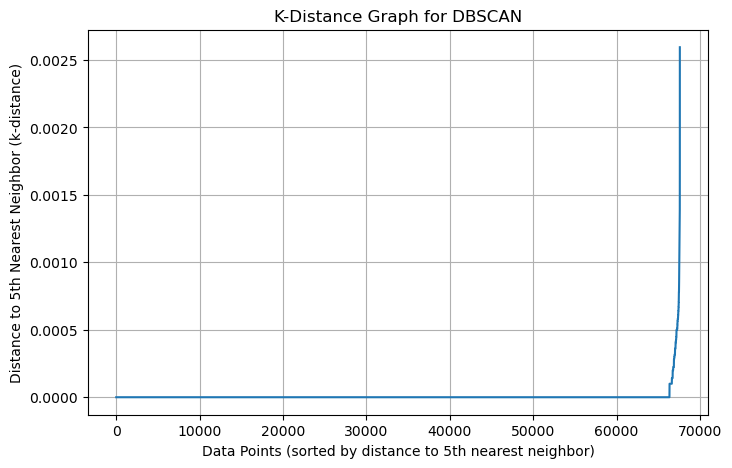

In [20]:
df_area_1 = df_pd[df_pd["AREA"]==1]
neighbors = NearestNeighbors(n_neighbors=50)
neighbors_fit = neighbors.fit(df_area_1)

distances, indices = neighbors_fit.kneighbors(df_area_1)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN')
plt.xlabel('Data Points (sorted by distance to 5th nearest neighbor)')
plt.ylabel('Distance to 5th Nearest Neighbor (k-distance)')
plt.grid(True)
plt.show()

## Clustering with DBSCAN for Area 1 (Central)

In [43]:
df_area_1 = df_pd[df_pd["AREA"]==1]
print(df_area_1.shape)
dbscan_central = DBSCAN(eps=0.00135, min_samples=5)
clusters = dbscan_central.fit_predict(df_area_1)

(67580, 4)


In [44]:
labels = dbscan_central.labels_
df_area_1["cluster"] = labels
df_area_1["cluster"].unique()


/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_16749/1557961500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_1["cluster"] = labels


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, -1,  9])

In [49]:
df_clusters = df_area_1[df_area_1["cluster"]!=-1]
df_clusters["cluster"].unique()


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [50]:
m = folium.Map(location=[df_clusters['LAT'].mean(), df_clusters['LON'].mean()], zoom_start=15)
colors =  ['red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black']
# Add points to the map
count = 0
for i, row in df_clusters.iterrows():
    print(row["cluster"])
    count+=1
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=8,
        color=colors[int(row['cluster'])],
        fill=True,
        fill_color=colors[int(row['cluster'])],
        fill_opacity=0.6,
        popup=f"Cluster: {int(row['cluster'])}"
    ).add_to(m)
print(count)

m.save('clusters/central_10_dbscan.html')

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
